In [1]:
import numpy as np
#from scipy import stats as stats
from matplotlib import pyplot as plt

In [19]:
width = 50
height = 40
duration = 30

poisson_scale = 10.0
mean_background = 300.5

covariance = np.array([[5,0,0], [0,1,0],[0,0, 0.1]])
D = np.linalg.inv(covariance)
amplitude = 20000

x = np.linspace(-width/2, width/2, num=width)
y = np.linspace(-height/2, height/2, num=height)
z = np.linspace(-duration/2, duration/2, num=duration)

xx = np.meshgrid(x, y, z)

arg = 0

for i in range(3):
    for j in range(3):
        arg += D[i,j]*xx[i]*xx[j]

original_image = mean_background + amplitude*np.exp(-arg/2)
original_intensity = original_image.sum() - width*height*duration*mean_background

original profile (no noise):


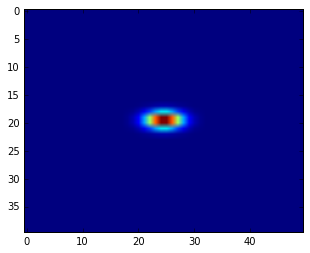

2d integrated intensity (x):


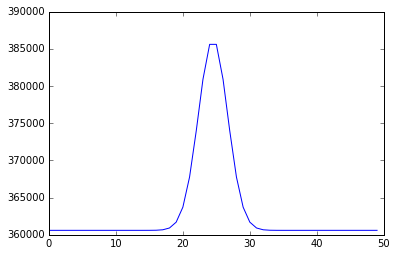

2d integrated intensity (y):


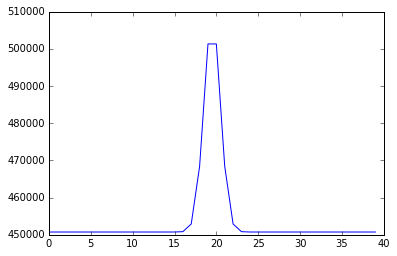

2d integrated intensity (z):


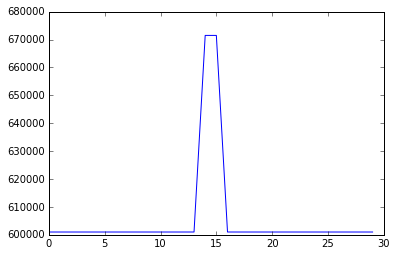

total integrated intensity: 140932.9485066943


In [20]:
print("original profile (no noise):")
plt.imshow(original_image[:,:,15])
plt.show()

print("2d integrated intensity (x):")
integrated2d_x = [ original_image[:,x,:].sum() for x in range(width)]
plt.plot(integrated2d_x)
plt.show()

print("2d integrated intensity (y):")
integrated2d_y = [ original_image[y,:,:].sum() for y in range(height)]
plt.plot(integrated2d_y)
plt.show()

print("2d integrated intensity (z):")
integrated2d_z = [ original_image[:,:,z].sum() for z in range(duration)]
plt.plot(integrated2d_z)
plt.show()

print("total integrated intensity:", original_intensity)

noisy image:


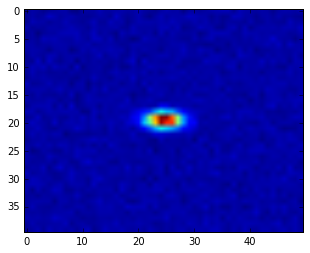

2d integrated noisy intensity (x):


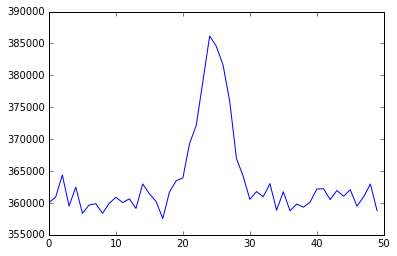

2d integrated noisy intensity (y):


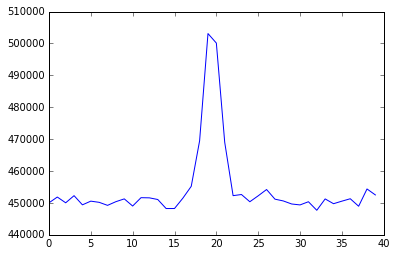

2d integrated noisy intensity (z):


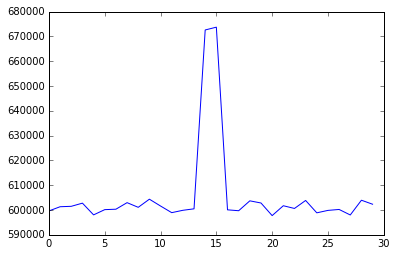

In [21]:
def generate_noisy():
    s = np.random.normal(0.0, 1.0, width*height*duration)
    noise = np.reshape(s, [height, width, duration])*np.sqrt(original_image*poisson_scale)
    noisy_image = original_image + noise
    return noisy_image

im = generate_noisy()

print("noisy image:")
plt.imshow(im[:,:,15])
plt.show()

print("2d integrated noisy intensity (x):")
integrated2d_x = [ im[:,x,:].sum() for x in range(width)]
plt.plot(integrated2d_x)
plt.show()

print("2d integrated noisy intensity (y):")
integrated2d_y = [ im[y,:,:].sum() for y in range(height)]
plt.plot(integrated2d_y)
plt.show()

print("2d integrated noisy intensity (z):")
integrated2d_z = [ im[:,:,z].sum() for z in range(duration)]
plt.plot(integrated2d_z)
plt.show()


peak mask:


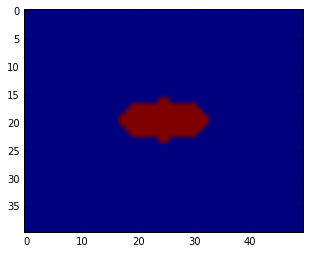

background mask:


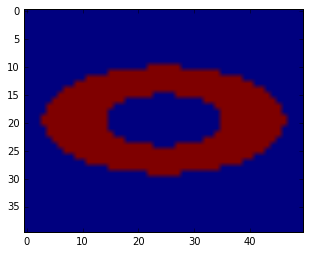

In [22]:
r1 = 4
r2 = 5
r3 = 10

peak_mask = arg < r1*r1
background_mask = (arg > r2*r2) * (arg < r3*r3)
print('peak mask:')
plt.imshow(peak_mask[:,:,15])
plt.show()

print('background mask:')
plt.imshow(background_mask[:,:,15])
plt.show()

In [23]:
def integrate():
    noisy_image = generate_noisy()
    npeak = peak_mask.sum()
    nbkg = background_mask.sum()
    
    bkg = (noisy_image*background_mask).sum() / nbkg
    bvar = ((background_mask*(noisy_image-bkg))**2).sum() / (nbkg-1)
    
    scale = bvar / bkg
    
    total = (peak_mask*noisy_image).sum()
    peak = total - npeak*bkg
    
    variance = scale*total + npeak*npeak*bkg/nbkg
    
    return peak, np.sqrt(variance)



noisy_image = generate_noisy()

npeak = peak_mask.sum()
nbkg = background_mask.sum()

obs_background = (background_mask*noisy_image).sum() / nbkg
peak_intensity = (peak_mask*noisy_image).sum() - npeak*obs_background
exact_sigma = np.sqrt(poisson_scale*original_intensity)

std2_bkg = ((background_mask*(noisy_image-obs_background))**2).sum() / (nbkg-1)
obs_scale = std2_bkg / obs_background

calc_sigma = np.sqrt(obs_scale*(peak_mask*noisy_image).sum() +npeak*npeak*std2_bkg/nbkg)

print("exact background:", mean_background)
print("calculated background:", obs_background)
print("calculted scale:", obs_scale)

print("exact intensity:", original_intensity)
print("calculated intensity:", peak_intensity)

print("error in intensity:", (peak_intensity-original_intensity)/original_intensity*100, "%")

print("exact sigma:", exact_sigma)
print("calculated sigma:", calc_sigma)
print("delta I / sigma:", (peak_intensity-original_intensity)/exact_sigma)


exact background: 300.5
calculated background: 301.38770738753556
calculted scale: 10.114726634319187
exact intensity: 140932.9485066943
calculated intensity: 139040.70586687795
error in intensity: -1.342654545914404 %
exact sigma: 1187.1518374104228
calculated sigma: 1407.6885520092167
delta I / sigma: -1.5939348111897416


1469.3551317815952 1393.0135599122596


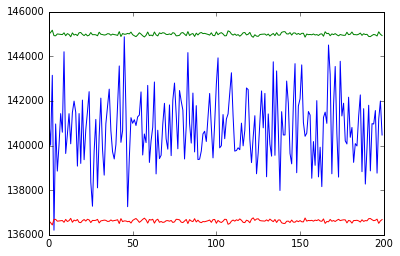

In [24]:
Is = []
sigmas = []

for i in range(200):
    I,s = integrate()
    Is.append(I)
    sigmas.append(s)
    
Is = np.array(Is)
sigmas = np.array(sigmas)
print(Is.std(), sigmas.mean())

plt.plot(Is)
plt.plot(Is.mean()+3*sigmas)
plt.plot(Is.mean()-3*sigmas)
plt.show()

In [ ]:
print(npeak*std2_bkg)
print(obs_scale*obs_background*npeak)

In [ ]:

print(np.sqrt(var1+var2))
print(np.sqrt(var1+var2+2*np.sqrt(var1*var2)))

In [ ]:
shells = []
totals = []
means = []
rs = []
rmax = 10
nmax = 100

total = 0

for i in range(nmax):
    r = i/nmax*rmax
    mask = (arg >= (r-1)**2) * (arg < r**2)
    
    if (mask.sum() < 1):
        continue
    
    shell_intensity = (noisy_image * mask).sum()
    total += shell_intensity
    totals.append(total)
    mean_intensity = (noisy_image * mask).sum() / mask.sum()
    shells.append(shell_intensity)
    means.append(mean_intensity)
    rs.append(r)
    
plt.scatter(rs, shells)
plt.show()

plt.scatter(rs, totals)
plt.show()
    
plt.scatter(rs, means)
plt.show()

In [ ]:
4 * np.pi / 3 / np.linalg.det(D)

In [ ]:
prediction = []

for i in range(len(rs)-1):
    r1 = rs[i+1]
    r0 = rs[i]
    rav = 0.5*r0 + 0.5*r1
    
    rational = rav**2 * (r1-r0) / (r1**3 - r0**3)
    profile = 3*np.exp(-rav**2 / 2)*rational
    prediction.append(profile)


plt.scatter(rs[1:], prediction)
plt.show()

In [ ]:
totals[-1:][0] / (4*np.pi / 3 / np.sqrt(np.linalg.det(D)) * rs[-1:][0]**3)

In [ ]:
np.linalg.det(D)

In [ ]:
totals[-1:][0] / (4*np.pi / 3) / rs[-1:][0]**3 / mean_background

In [ ]:
D